In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Creating a Pandas dataframe

In [2]:
training_data = pd.read_csv('/Users/abdulbari/Downloads/MNIST_CSV/mnist_train.csv')
testing_data = pd.read_csv('/Users/abdulbari/Downloads/MNIST_CSV/mnist_test.csv')

training_data.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Creating a train and test split

In [3]:
# changing the pd dataframe into a np array and transposing that entire matrix so that each column is our training/testing example
training_data = np.array(training_data)
testing_data = np.array(testing_data)

np.random.shuffle(training_data)

# training data
training_data = training_data.T
y_train = training_data[0,:] 
X_train = training_data[1:, :] 
X_train = X_train / 255

# test data
testing_data = testing_data.T
y_test = testing_data[0] 
X_test = testing_data[1:, :] 
X_test = X_test / 255

print("labels: ", np.unique(training_data[0]))

# plotting an image
def show_image(index, X):
    current_image = X[:,index]
    current_image = current_image.reshape(28,28) 
    plt.imshow(current_image)
    plt.axis(False)
    plt.show()
    

labels:  [0 1 2 3 4 5 6 7 8 9]


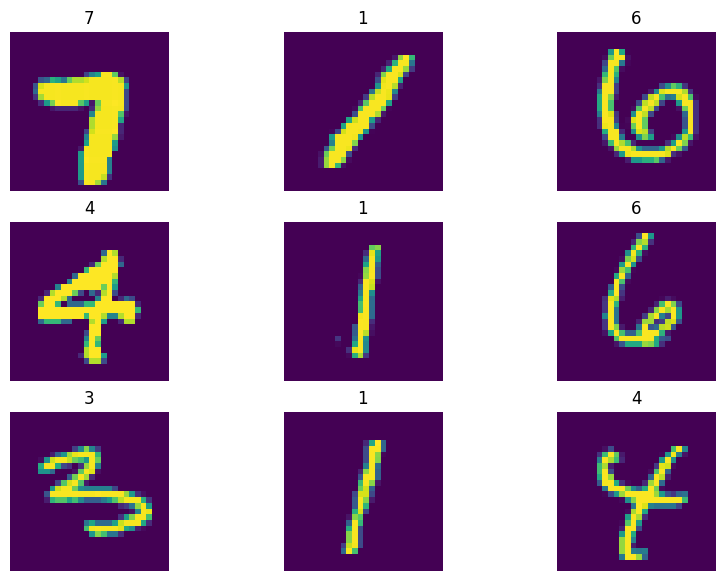

In [4]:
import random

def view_data():
  plt.figure(figsize=(10, 7))

  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    rand_index = random.choice(range(len(X_train)))
    image = np.reshape(X_train[:, rand_index], (28, 28))
    plt.imshow(image)
    plt.title(y_train[rand_index])
    plt.axis(False)

view_data()

# Heart of the NN

In [5]:
def init_params():
    W1 = np.random.rand(128, 784) - 0.5 # this generates a matrix with randomised weights (between 0 and 1) for each of the nodes from 784 node input layer to the 128 node first hidden layer
    W2 = np.random.rand(10, 128) - 0.5  # this generates a matrix with randomised weights (between 0 and 1) for each of the nodes from 128 node first hidden layer to the 10 node second hidden layer
    b1 = np.random.rand(128, 1) - 0.5 # generates a randomised bias vector for the first hidden layer
    b2 = np.random.rand(10, 1) - 0.5  # generates a randomised bias vector for the second hidden layer
    return W1, W2, b1, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def deriv_ReLU(Z):
    return Z > 0

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def deriv_sigmoid(Z):
    return sigmoid(Z) * (1 - sigmoid(Z))

def softmax(Z):
    Z_shifted = Z - np.max(Z, axis=0)  # Shift Z by max for numerical stability
    exp_Z = np.exp(Z_shifted)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def forward_prop(W1, W2, b1, b2, X, activation):
    Z1 = W1.dot(X) + b1 # unactivated first hidden layer
    if(activation == "ReLU"):
        A1 = ReLU(Z1) # activating the first hidden layer
    elif(activation == "sigmoid"):
        A1 = sigmoid(Z1) # activating the first hidden layer
    Z2 = W2.dot(A1) + b2 # unactivated second hidden layer
    A2 = softmax(Z2) # softmax returns a probablity distribution of the output
    return Z1, Z2, A1, A2

def one_hot(y_labels):
    one_hot_y = np.zeros((y_labels.size, 10)) # here we are creating a zero matrix in which we would one hot encode our y label
    one_hot_y[np.arange(y_labels.size), y_labels] = 1 # this is setting the value on this index to 1 (np.arange(y_labels.size) creates an array of 0s of size y_labels.size)
    one_hot_y = one_hot_y.T # makes it a column (previously each row was an example, now each column is an example)
    return one_hot_y

def back_prop(Z1, Z2, A1, A2, W2, X, Y, activation):
    m = Y.size
    one_hot_y = one_hot(Y)
    dZ2 = A2 - one_hot_y 
    dW2 = 1/m * dZ2.dot(A1.T) 
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    if(activation == "ReLU"):   
        dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1) 
    elif(activation == "sigmoid"):    
        dZ1 = W2.T.dot(dZ2) * deriv_sigmoid(Z1) 
    dW1 = 1/m * dZ1.dot(X.T) 
    db1 = 1/m *  np.sum(dZ1, axis=1, keepdims=True)      
    return dW1, dW2, db1, db2

def update_params(W1, W2, b1, b2, dW1, dW2, db1, db2, lr):
    W1 = W1 - lr * dW1
    W2 = W2 - lr * dW2
    b1 = b1 - lr * db1 
    b2 = b2 - lr * db2 
    return W1, W2, b1, b2


# Backprop Explanation


- The loss of the current neuron depends on three key factors:
  1. **Weight** 
  2. **Bias** 
  3. **Activations from the previous layer** 

1. The variable dZ2 represents the gradient of the loss with respect to Z2. It essentially tells us how much the loss changes after an iteration. This gradient is used during backpropagation to update the parameters of the network, thereby reducing the loss, which is the goal of training the neural network.

2. The variable dW2 represents the gradient of the loss with respect to the weights in the second hidden layer, denoted by W2. This gradient indicates how the weights W2 affect the loss.

   - This is calculated using the chain rule, where a small change in W2 first slightly changes Z2, which in turn slightly changes A2, and finally, this change affects the loss. Mathematically, this is expressed as: $$\frac{dL}{dW2} = \frac{\partial Z2}{\partial W2} \cdot \frac{\partial A2}{\partial Z2} \cdot \frac{\partial L}{\partial A2}$$
      - The derivative of Z2 with respect to W2 is given by: $$\frac{\partial Z_2}{\partial W_2} = A1 $$
      - The derivative of A2 with respect to Z2 is the derivative of the softmax (however there is no need for this because this is apparently included in dZ2)
      - The derivative of L with respect to A2 is the derivative of the loss function which is just dZ2
  - We have 1/m because it averages the gradient over all training examples

3. The variable db2 represents the gradient of the loss with respect to the bias in the second hidden layer, denoted by b2. This gradient indicates how the bias b2 affect the loss.

    - This is calculated using the chain rule, where a small change in b2 first slightly changes Z2, which in turn slightly changes A2, and finally, this change affects the loss. Mathematically, this is expressed as: $$\frac{dL}{db2} = \frac{\partial Z2}{\partial b2} \cdot \frac{\partial A2}{\partial Z2} \cdot \frac{\partial L}{\partial A2}$$
      - The derivative of Z2 with respect to b2 is given by: $$\frac{\partial Z_2}{\partial b_2} = 1 $$
      - The derivative of A2 with respect to Z2 is the derivative of the softmax (however there is no need for this because this is apparently included in dZ2)
      - The derivative of L with respect to A2 is the derivative of the loss function which is just dZ2
  - We take the sum of all values of dZ2 because the bias is shared across all the neurons in a single layer and each neuron’s bias should be adjusted based on the collective error.
  - We have 1/m because it averages the gradient over all training examples

4. The variable dZ1 represents the how sensitive the loss is to the activation of the previous layer.

    - This is calculated using the chain rule, where a small change in Z1 first slightly changes A1, which in turn slightly changes Z2, which changes A2 and finally, this change affects the loss. Mathematically, this is expressed as: $$\frac{dL}{dZ1} = \frac{\partial A1}{\partial Z1} \cdot \frac{\partial Z2}{\partial A1} \cdot \frac{\partial A2}{\partial Z2} \cdot \frac{\partial L}{\partial A2}$$    
      - The derivative of A1 with respect to Z1 is the derivative of the ReLU function which we have described in the **deriv_ReLU()** function
      - The derivative of Z2 with respect to A1 is given by: $$\frac{\partial Z_2}{\partial A_1} = W2 $$
      - The derivative of A2 with respect to Z2 is the derivative of the softmax (however there is no need for this because this is apparently included in dZ2)
      - The derivative of L with respect to A2 is the derivative of the loss function which is just dZ2

5. The variable dW1 represents the gradient of the loss with respect to the weights in the first hidden layer, denoted by W1. This gradient indicates how the weights W1 affect the loss. (Essentially repeating the same process but 1 layer back)
    - This is calculated using the chain rule, where a small change in W1 first slightly changes Z1, which in turn slightly changes A1, and finally, this change affects the loss. Mathematically, this is expressed as: $$\frac{dL}{dW1} = \frac{\partial Z1}{\partial W1} \cdot \frac{\partial A1}{\partial Z1} \cdot \frac{\partial L}{\partial A1}$$
      - The derivative of Z1 with respect to W1 is given by: $$\frac{\partial Z_1}{\partial W_1} = X $$
      - The derivative of A1 with respect to Z1 is the derivative of the ReLU (however there is no need for this because this is included in dZ1)
      - The derivative of L with respect to A1 is the derivative of the loss function which is just dZ1
    - We have 1/m because it averages the gradient over all training examples

6. The variable db1 represents the gradient of the loss with respect to the bias in the first hidden layer, denoted by b1. This gradient indicates how the bias b1 affect the loss.

    - This is calculated using the chain rule, where a small change in b1 first slightly changes Z1, which in turn slightly changes A1, and finally, this change affects the loss. Mathematically, this is expressed as: $$\frac{dL}{db1} = \frac{\partial Z1}{\partial b1} \cdot \frac{\partial A1}{\partial Z1} \cdot \frac{\partial L}{\partial A1}$$
      - The derivative of Z1 with respect to b1 is given by: $$\frac{\partial Z_1}{\partial b_1} = 1 $$
      - The derivative of A1 with respect to Z1 is the derivative of the ReLU (however there is no need for this because this is included in dZ2)
      - The derivative of L with respect to A1 is the derivative of the loss function which is just dZ1
    - We take the sum of all values of dZ1 because the bias is shared across all the neurons in a single layer and each neuron’s bias should be adjusted based on the collective error.
    - We have 1/m because it averages the gradient over all training examples 


# Gradient Descent implementation

In [6]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, lr, iterations, activation):
    W1, W2, b1, b2 = init_params()
    accuracies = []  # List to store accuracy values for each iteration
    for i in range(iterations):
        Z1, Z2, A1, A2 = forward_prop(W1, W2, b1, b2, X, activation)
        dW1, dW2, db1, db2 = back_prop(Z1, Z1, A1, A2, W2, X, Y, activation)
        W1, W2, b1, b2 = update_params(W1, W2, b1, b2, dW1, dW2, db1, db2, lr)

        accuracy = get_accuracy(get_predictions(A2), Y)
        accuracies.append(accuracy)

        if (i % 50 == 0):
            print(f"Iterations: {i}, Accuracy: {accuracy:.2f}")
            
    return W1, W2, b1, b2, accuracies

def accuracy_graph(accuracies):
    # Plot accuracy over iterations
    plt.plot(range(1, len(accuracies) + 1), accuracies)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Iterations')
    plt.grid(True)
    plt.show()    


# Gradient Descent (ReLU)

Iterations: 0, Accuracy: 0.06
Iterations: 50, Accuracy: 0.76
Iterations: 100, Accuracy: 0.83
Iterations: 150, Accuracy: 0.85
Iterations: 200, Accuracy: 0.87
Iterations: 250, Accuracy: 0.88
Iterations: 300, Accuracy: 0.89
Iterations: 350, Accuracy: 0.89
Iterations: 400, Accuracy: 0.90
Iterations: 450, Accuracy: 0.90


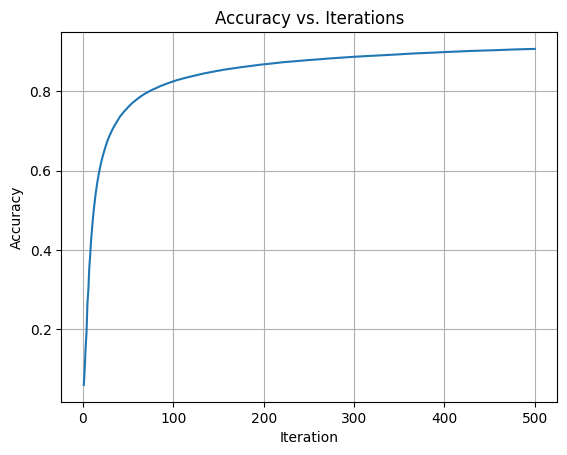

In [7]:
# Run gradient descent
W1, W2, b1, b2, accuracies = gradient_descent(X_train, y_train, lr=0.1, iterations=500, activation="ReLU")

accuracy_graph(accuracies)


# Gradient Descent (Sigmoid)

Iterations: 0, Accuracy: 0.08
Iterations: 50, Accuracy: 0.60
Iterations: 100, Accuracy: 0.74
Iterations: 150, Accuracy: 0.79
Iterations: 200, Accuracy: 0.82
Iterations: 250, Accuracy: 0.83
Iterations: 300, Accuracy: 0.84
Iterations: 350, Accuracy: 0.85
Iterations: 400, Accuracy: 0.86
Iterations: 450, Accuracy: 0.87


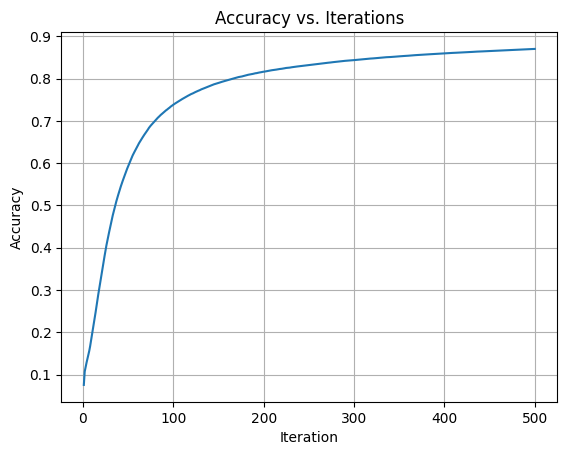

In [8]:
# Run gradient descent
W1, W2, b1, b2, accuracies = gradient_descent(X_train, y_train, lr=0.1, iterations=500, activation="sigmoid")

accuracy_graph(accuracies)


# Prediction function

In [9]:
def make_predictions(W1, W2, b1, b2, X, activation):
    Z1, Z2, A1, A2 = forward_prop(W1, W2, b1, b2, X, activation)
    predictions = get_predictions(A2)
    return predictions

def test_predictions(W1, W2, b1, b2, activation):
    
    plt.figure(figsize=(10, 7))
    
    for i in range(9):
        plt.subplot(3, 3, i+1)
        index = random.choice(range(len(X_train)))
        current_image = X_train[:, index, None]
        prediction = make_predictions(W1, W2, b1, b2, current_image, activation)
        label = y_train[index, None]
        current_image = np.reshape(X_train[:, index], (28, 28))
        
        if prediction == label:
            title_color = "green"  
        else:
            title_color = "red"

        plt.imshow(current_image)
        plt.title(f"Prediction: {prediction}, Label: {label}", color=title_color)
        plt.axis(False)

    plt.show()
        

# ReLU Prediction

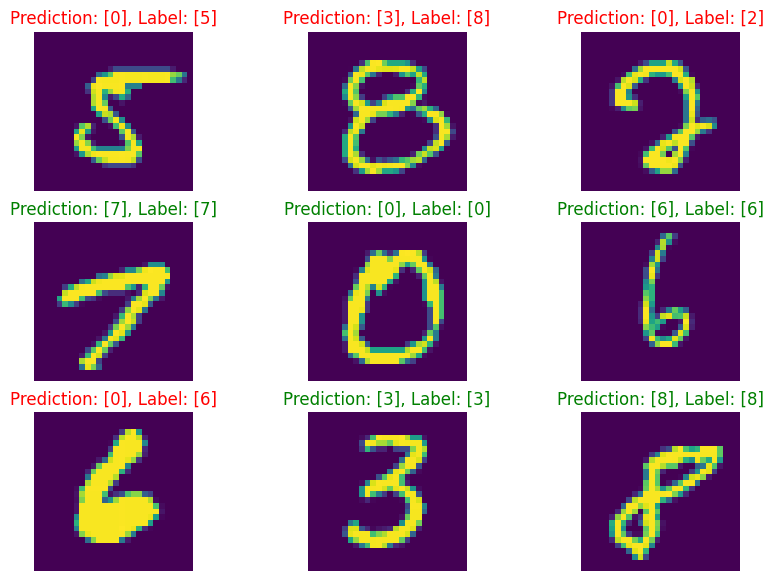

Accuracy on test set:  0.7683768376837684


In [10]:
test_predictions(W1, W2, b1, b2, activation="ReLU")


testset_predictions_relu = make_predictions(W1, W2, b1, b2, X_test, activation="ReLU")
print("Accuracy on test set: ", get_accuracy(testset_predictions_relu, y_test))

# Sigmoid Prediction

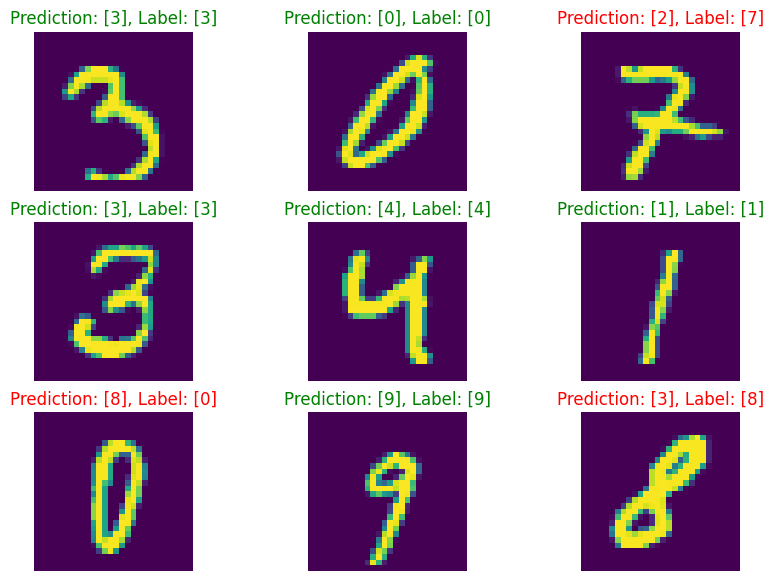

Accuracy on test set:  0.877987798779878


In [11]:
test_predictions(W1, W2, b1, b2, activation="sigmoid")


testset_predictions_sigmoid = make_predictions(W1, W2, b1, b2, X_test, activation="sigmoid")
print("Accuracy on test set: ",get_accuracy(testset_predictions_sigmoid, y_test))

In [44]:
# prints out random incorrect predictions
def incorrect_predictions(activation):
    incorrect_images = []
    incorrect_labels = []

    predictions = make_predictions(W1, W2, b1, b2, X_test, activation)
    for i in range(len(predictions)):
        if(predictions[i] != y_test[i]):
            incorrect_images.append(X_test[:, i])
            incorrect_labels.append(y_test[i])

    incorrect_images = np.array(incorrect_images)
    incorrect_labels = np.array(incorrect_labels)

    plt.figure(figsize=(10, 7))
    for j in range(9):
        plt.subplot(3, 3, j+1)
        index = random.choice(range(len(incorrect_images)))
        current_image = incorrect_images[index].reshape(28, 28)
        current_image_prediction = make_predictions(W1, W2, b1, b2, incorrect_images[index].reshape(-1, 1), activation)
        current_image_label = incorrect_labels[index]

        plt.imshow(current_image)
        plt.title(f"Prediction: {current_image_prediction}, Label: {current_image_label}", color="red")
        plt.axis(False)


# Identifying Incorrect Predictions (ReLU)

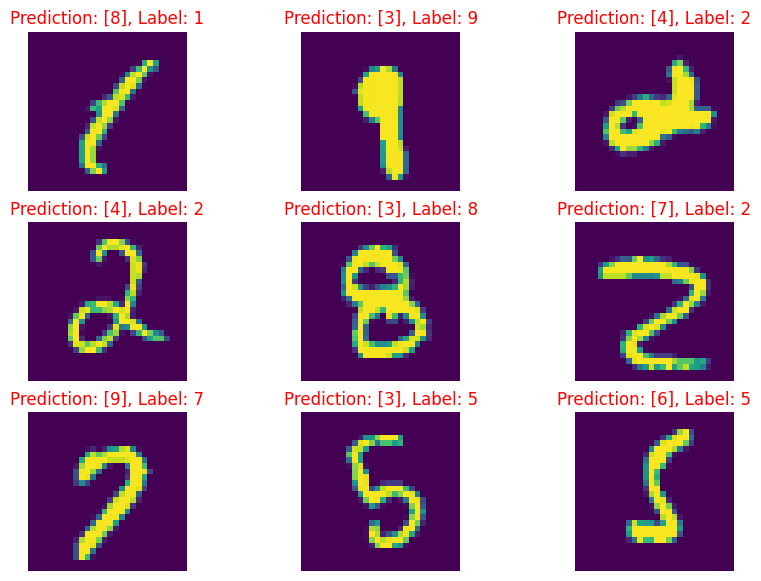

In [45]:
incorrect_predictions(activation="ReLU")

# Identifying Incorrect Predictions (Sigmoid)

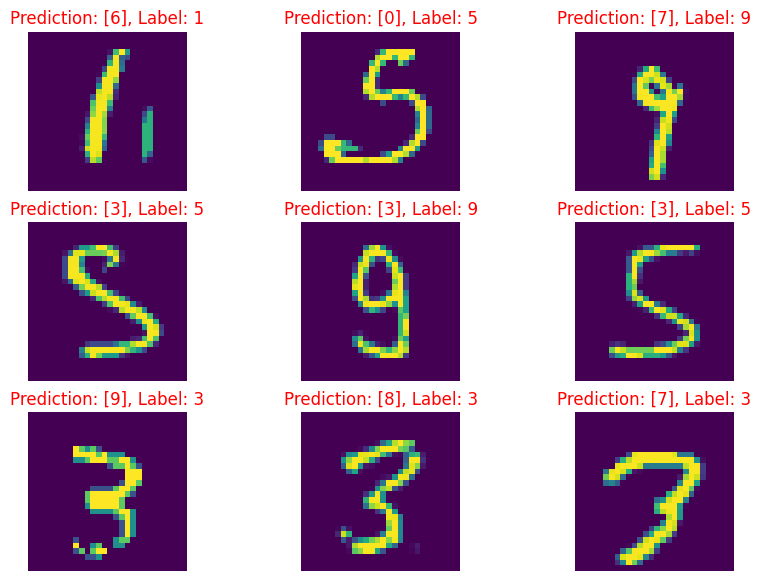

In [46]:
incorrect_predictions("sigmoid")

# Implementation in TensorFlow

In [ ]:
import tensorflow as tf

# Making tensors
X_train = tf.constant(tf.transpose(X_train))
y_train = tf.constant(y_train)

X_test = tf.constant(tf.transpose(X_test))
y_test = tf.constant(y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(TensorShape([59999, 784]),
 TensorShape([9999, 784]),
 TensorShape([59999]),
 TensorShape([9999]))

## Viewing the data

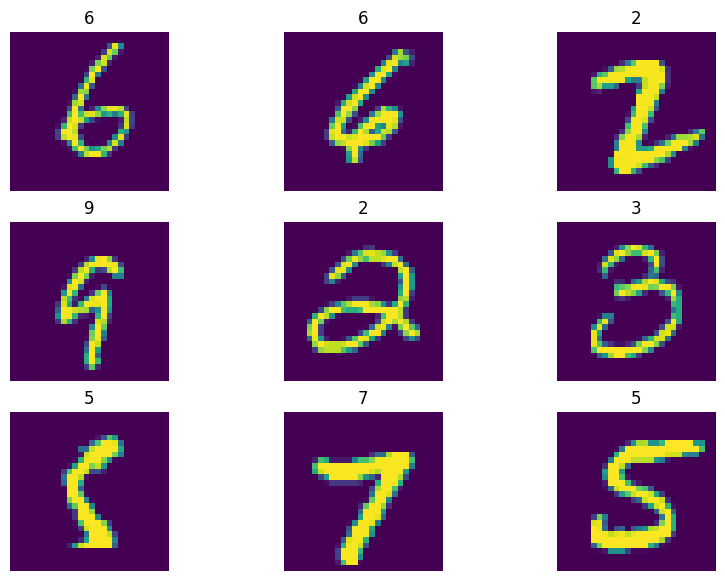

In [ ]:
import random

plt.figure(figsize=(10, 7))

for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  rand_index = random.choice(range(len(X_train)))
  image = tf.reshape(X_train[rand_index], (28, 28)).numpy()
  plt.imshow(image)
  plt.title(y_train[rand_index].numpy())
  plt.axis(False)


## Neural Network in tensorflow

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.5542 - loss: 1.8214 - val_accuracy: 0.8294 - val_loss: 0.8602
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - accuracy: 0.8356 - loss: 0.7835 - val_accuracy: 0.8695 - val_loss: 0.5613
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step - accuracy: 0.8679 - loss: 0.5473 - val_accuracy: 0.8868 - val_loss: 0.4562
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - accuracy: 0.8848 - loss: 0.4575 - val_accuracy: 0.8940 - val_loss: 0.4041
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 632us/step - accuracy: 0.8915 - loss: 0.4078 - val_accuracy: 0.9004 - val_loss: 0.3717
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - accuracy: 0.8960 - loss: 0.3799 - val_accuracy: 0.9033 - val_loss: 0.3508
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step - accuracy: 0.9003 - loss: 0.3610 - val_accuracy: 0.9068 - val_loss: 0.3353
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step - accuracy: 0.9028 -

<Axes: >

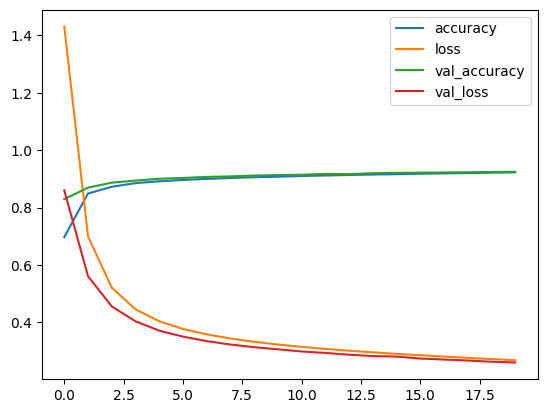

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="sigmoid"),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])

model_history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

pd.DataFrame(model_history.history).plot()

## Testing predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


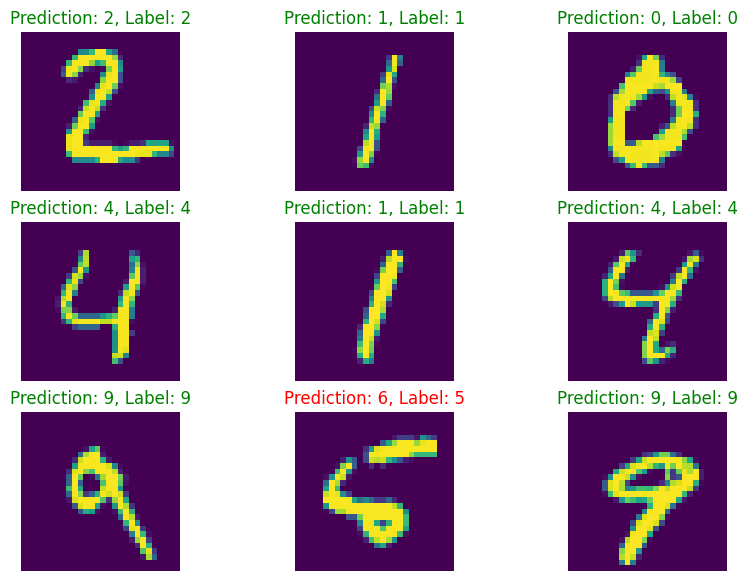

In [ ]:
def test_predictions():
  plt.figure(figsize=(10, 7))

  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    current_image = X_test[i] 
    current_image = tf.reshape(current_image, (28, 28)) # Reshape to match the expected input shape of the model (assuming it's a 28x28 image) (1 means that we are only testing one image at a time)
    prediction = model.predict(tf.reshape(current_image, (1, -1)))
    prediction = tf.argmax(prediction, axis=1)
    prediction = prediction.numpy()[0]
    label = y_test[i].numpy()

    if prediction == label:
      title_color = "green"  
    else:
      title_color = "red"

    plt.imshow(current_image)
    plt.title(f"Prediction: {prediction}, Label: {label}", color=title_color)
    plt.axis(False)

  plt.show()
  
test_predictions()